## Satellite Image Segmentation Notebook

This notebook builds a patch-based semantic segmentation dataset from the DubaiDataset tiles.

Main steps.
1) Load RGB images and color-coded masks.
2) Crop to a size divisible by the patch size.
3) Split into non-overlapping patches.
4) Convert mask colors to integer class IDs.
5) One-hot encode labels for training.
6) Train/test split.


In [111]:
import pandas as pd
import os
import cv2
import numpy as np  
from matplotlib import pyplot as plt
import random

In [112]:
# Patch size in pixels.
# All images and masks will be cropped so height and width are multiples of this value.
image_patch_size = 256

In [113]:
# Quick single-image read to validate paths and file formats.
# `cv2.imread(..., 1)` loads a 3-channel BGR image.
image = cv2.imread("../DubaiDataset/Tile 1/images/image_part_001.jpg",1)

In [114]:
image.shape # (644,797,3) is (height, width, channels)

(644, 797, 3)

### Read All The Images and Then Crop and Patchify Them

#### Patch extraction helper

`extract_patches` slices an image into non-overlapping patches.

In [115]:
# Utility to extract (patch_size x patch_size) tiles from an image.
# Default stride equals patch_size for non-overlapping patches.
# Returns an array of shape (N, patch_size, patch_size, C) or (N, patch_size, patch_size) for single-channel masks.

def extract_patches(image, patch_size, stride=None):
    if stride is None:
        stride = patch_size

    h, w = image.shape[:2]
    patches = []

    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = image[y:y+patch_size, x:x+patch_size]
            patches.append(patch)

    return np.array(patches)

#### Load tiles, crop, and patch

Iterate each `Tile {id}` folder, read the image and its matching mask by filename, crop both to the same divisible size, then extract aligned patches.

Image preprocessing.
- Convert BGR to RGB for visualization and consistency.
- Normalize to [0, 1] by dividing by 255.

Mask preprocessing.
- Convert BGR to RGB so class colors match the hex definitions below.
- Keep raw RGB masks for now.


In [116]:
dataset_root_folder = '../DubaiDataset'
image_dataset = []
mask_dataset = []
        
for tile_id in range(1, 8):
    img_dir = os.path.join(dataset_root_folder, f"Tile {tile_id}", "images")
    mask_dir = os.path.join(dataset_root_folder, f"Tile {tile_id}", "masks")
    if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
        continue

    for fname in sorted(os.listdir(img_dir)):
        if not fname.endswith(".jpg"):
            continue

        img_path = os.path.join(img_dir, fname)
        mask_path = os.path.join(mask_dir, fname.replace(".jpg", ".png"))

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        if image is None or mask is None:
            continue
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        h, w = image.shape[:2]
        size_x = (w // image_patch_size) * image_patch_size
        size_y = (h // image_patch_size) * image_patch_size

        image = image[0:size_y, 0:size_x]
        mask = mask[0:size_y, 0:size_x]

        image_patches = extract_patches(image, image_patch_size)
        mask_patches = extract_patches(mask, image_patch_size)

        for img_p, msk_p in zip(image_patches, mask_patches):
            image_dataset.append(img_p.astype(np.float32) / 255.0)
            mask_dataset.append(msk_p)


In [117]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [118]:
image_dataset[0].shape

(256, 256, 3)

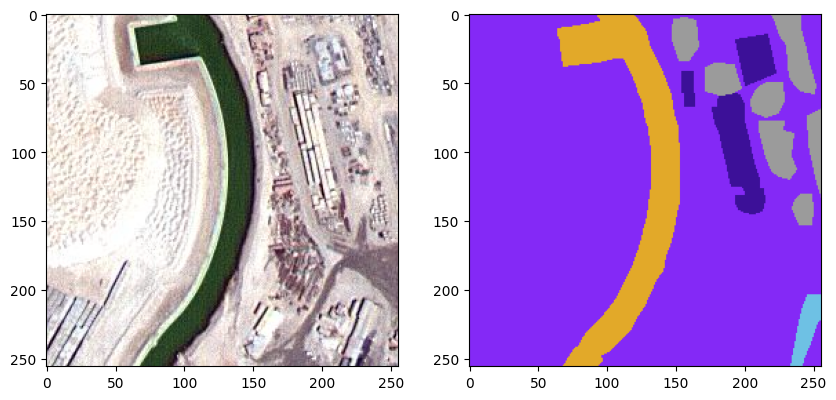

In [119]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(image_dataset[0])
plt.subplot(122)
plt.imshow(mask_dataset[0])

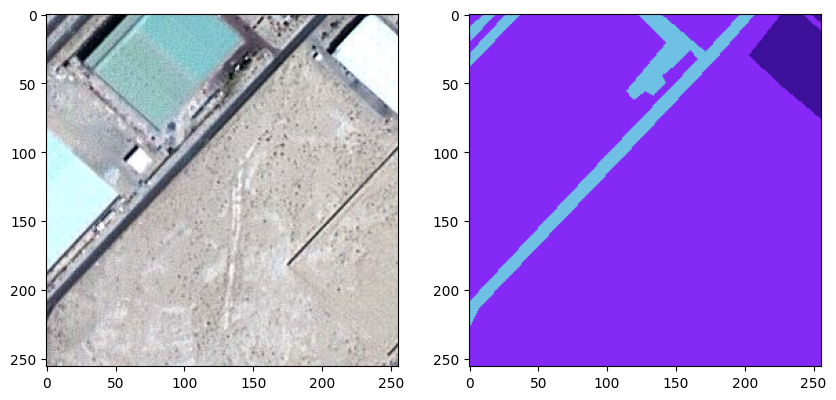

In [120]:
randome_img_id = random.randint(0, len(image_dataset)-1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(image_dataset[randome_img_id])
plt.subplot(122)
plt.imshow(mask_dataset[randome_img_id])

### Mask Label Processing: One-Hot Encoding
The masks are color-coded. Each pixel color corresponds to a class. We convert RGB masks into a 2D label mask where each pixel stores the class ID (0..K-1).

After conversion.
- Shape becomes (H, W).
- Values are integers.
- Safe for one-hot encoding and training.

In [121]:
class_building = "3C1098"
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0, 2, 4))) # 16-bit because of hex
class_building

array([ 60,  16, 152])

In [122]:
class_land = "8429F6"
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0, 2, 4))) # 16-bit because of hex
class_land

array([132,  41, 246])

In [123]:
class_road = "6EC1E4"
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0, 2, 4))) # 16-bit because of hex
class_road 

array([110, 193, 228])

In [124]:
class_vegetation = "FEDD3A"
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0, 2, 4))) # 16-bit because of hex
class_vegetation

array([254, 221,  58])

In [125]:
class_water = "E2A929"
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0, 2, 4))) # 16-bit because of hex
class_water

array([226, 169,  41])

In [126]:
class_unlabeled = "9B9B9B"
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0, 2, 4))) # 16-bit because of hex
class_unlabeled

array([155, 155, 155])

In [127]:
IGNORE_INDEX = 5

def rgb_to_label(mask_rgb):
    h, w = mask_rgb.shape[:2]
    label = np.zeros((h, w), dtype=np.uint8)

    label[np.all(mask_rgb == class_building, axis=-1)]   = 0
    label[np.all(mask_rgb == class_land, axis=-1)]       = 1
    label[np.all(mask_rgb == class_road, axis=-1)]       = 2
    label[np.all(mask_rgb == class_vegetation, axis=-1)] = 3
    label[np.all(mask_rgb == class_water, axis=-1)]      = 4

    label[np.all(mask_rgb == class_unlabeled, axis=-1)]  = IGNORE_INDEX
    return label


In [128]:
labels_dataset = np.array([rgb_to_label(m) for m in mask_dataset], dtype=np.uint8)

In [129]:
labels_dataset[5]

array([[2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [130]:
np.unique(labels_dataset)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

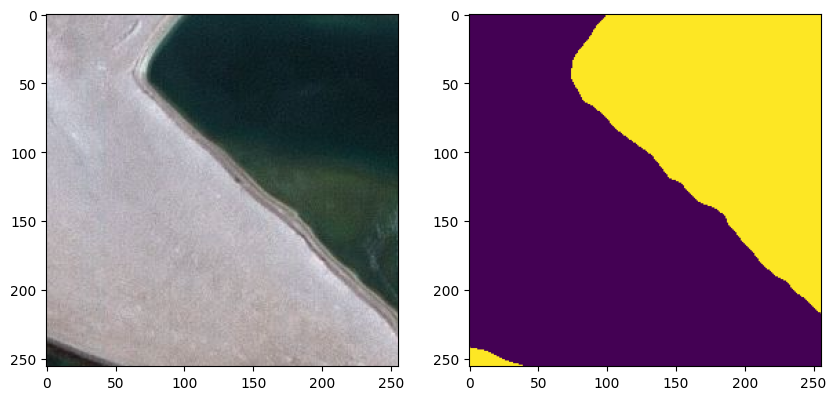

In [131]:
randome_img_id = random.randint(0, len(image_dataset)-1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(image_dataset[randome_img_id])
plt.subplot(122)
plt.imshow(labels_dataset[randome_img_id])   

### Train Test Split Method
We split patches into train and test sets.

In [132]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

import segmentation_models_pytorch as smp

In [133]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

torch.set_float32_matmul_precision("high")

if device.type == "cuda":
    torch.backends.cudnn.benchmark = True

mps


In [134]:
X_train, X_val, y_train, y_val = train_test_split(image_dataset,labels_dataset, test_size=0.2, random_state=100)

In [135]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(756, 256, 256, 3)
(189, 256, 256, 3)
(756, 256, 256)
(189, 256, 256)


## Deep Learning

In [136]:
class SegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        x = self.images[idx]
        y = self.masks[idx]
        
        # H x W x C  --> C x H x W for PyTorch
        x = torch.from_numpy(x).permute(2, 0, 1).float()
        
        # mask H x W x C  --> H x W for class index
        y = torch.from_numpy(y).long()
        return x,y

In [137]:
# DataLoaders
train_dataset = SegmentationDataset(X_train, y_train)
val_dataset = SegmentationDataset(X_val, y_val)

num_workers = 4 if device.type == "cuda" else 0
pin_memory = True if device.type == "cuda" else False

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False,
                            num_workers=num_workers,
                            pin_memory=pin_memory,
                            persistent_workers=True if num_workers > 0 else False,
                            prefetch_factor=2 if num_workers > 0 else None)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,
                        num_workers=num_workers,
                        pin_memory=pin_memory,
                        persistent_workers=True if num_workers > 0 else False,
                        prefetch_factor=2 if num_workers > 0 else None,)


In [138]:
# unet: Convolutional Neural Network for Image Segmentation
model = smp.Unet(encoder_name = "resnet34",
                 encoder_weights = 'imagenet',
                 in_channels = 3, # RGB images
                 classes = 5).to(device)

### Generating Loss Function

In [139]:
IGNORE_INDEX = 5  # unlabeled class

dice_loss = smp.losses.DiceLoss(
    mode="multiclass",
    ignore_index=IGNORE_INDEX
)

ce_loss = torch.nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)


def total_loss_fn(y_pred, y_true):
    return dice_loss(y_pred, y_true) + ce_loss(y_pred, y_true)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [140]:
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)
print(y.dtype)
print(torch.unique(y))


torch.Size([16, 3, 256, 256])
torch.Size([16, 256, 256])
torch.int64
tensor([0, 1, 2, 3, 4])


In [141]:
summary(
    model,
    input_size = (1,3,256,256),
    device = device
)

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [1, 5, 256, 256]          --
├─ResNetEncoder: 1-1                          [1, 3, 256, 256]          --
│    └─Conv2d: 2-1                            [1, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 128]         128
│    └─ReLU: 2-3                              [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                         [1, 64, 64, 64]           --
│    └─Sequential: 2-5                        [1, 64, 64, 64]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 64, 64]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 64, 64]           73,984
│    │    └─BasicBlock: 3-3                   [1, 64, 64, 64]           73,984
│    └─Sequential: 2-6                        [1, 128, 32, 32]          --
│    │    └─BasicBlock: 3-4                   [1, 128, 32, 32]          230,144

In [142]:
total_params = sum(p.numel() for p in model.parameters())
total_params

24436949

### Training & Validation Phase

In [143]:
# Training for one epoch
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    n_pix = 0

    for x, y in loader:
        x = x.to(device)              # float, MPS
        y = y.to(device, dtype=torch.long)  # long, MPS

        optimizer.zero_grad(set_to_none=True)
        pred = model(x)               # [B, C, H, W]
        loss = total_loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        b, _, h, w = pred.shape
        total_loss += loss.item() * (b * h * w)
        n_pix += (b * h * w)
        
    return total_loss / max(1, n_pix)

    

In [144]:
# valiation metric: Jaccard Coefficient (IoU)
NUM_CLASSES = 6
IGNORE_INDEX = 5

def jaccard_coef(y_pred, y_true): # IoU score
    pred = torch.argmax(y_pred, dim=1)  # [B, H, W]
    
    ious = []
    
    for cls in range(NUM_CLASSES):
        if cls == IGNORE_INDEX:
            continue
        
        pred_c = pred == cls          # [B, H, W]
        target_c = y_true == cls      # [B, H, W]
        
        intersection = (pred_c & target_c).sum().float()
        union = (pred_c | target_c).sum().float()
        
        if union > 0:
            ious.append((intersection+1.0) / (union+1.0))
        
    if len(ious) == 0:
        return torch.tensor(0.0, device=pred.device)
    
    return torch.mean(torch.stack(ious))    
    

In [145]:
def pixel_accuracy(pred, target):
    pred = torch.argmax(pred, dim=1)

    valid_mask = target != IGNORE_INDEX
    correct = (pred == target) & valid_mask

    return correct.sum().float() / valid_mask.sum().float()

In [146]:
# Validation for one epoch
def validate(model, loader):
    model.eval() # eval() is from nn.Module
    total_loss = 0
    total_iou= 0
    total_acc = 0
    n = 0
    
    with torch.no_grad(): # no gradient computation
        for x,y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            
            pred = model(x)
            loss = total_loss_fn(pred, y)
            
            total_loss += loss.item()
            total_iou += jaccard_coef(pred, y).item()
            total_acc += pixel_accuracy(pred, y).item()
            n += 1
    
    return (total_loss / n,
            total_iou / n,
            total_acc / n)  

In [147]:
# Run training and validation
history = {
    "train_loss": [],
    "val_loss": [],
    "val_iou": [],
    "val_acc": []
}
epochs = 15
for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader)
    val_loss, val_iou, val_acc = validate(model, val_loader)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_iou"].append(val_iou)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train Loss {train_loss:.4f} | "
        f"Val Loss {val_loss:.4f} | "
        f"IoU {val_iou:.4f} | "
        f"Accuracy {val_acc:.4f}"
    )


Epoch 1/15 | Train Loss 2.0121 | Val Loss 1.6003 | IoU 0.4694 | Accuracy 0.7064
Epoch 2/15 | Train Loss 1.4881 | Val Loss 1.1397 | IoU 0.5979 | Accuracy 0.8241
Epoch 3/15 | Train Loss 1.1897 | Val Loss 1.0354 | IoU 0.6392 | Accuracy 0.8416
Epoch 4/15 | Train Loss 0.9904 | Val Loss 0.8909 | IoU 0.6545 | Accuracy 0.8423
Epoch 5/15 | Train Loss 0.8440 | Val Loss 0.8252 | IoU 0.6570 | Accuracy 0.8453
Epoch 6/15 | Train Loss 0.7579 | Val Loss 0.7578 | IoU 0.6775 | Accuracy 0.8605
Epoch 7/15 | Train Loss 0.6982 | Val Loss 0.7062 | IoU 0.6914 | Accuracy 0.8660
Epoch 8/15 | Train Loss 0.6202 | Val Loss 0.6668 | IoU 0.7011 | Accuracy 0.8688
Epoch 9/15 | Train Loss 0.5643 | Val Loss 0.6813 | IoU 0.6924 | Accuracy 0.8642
Epoch 10/15 | Train Loss 0.5538 | Val Loss 0.6444 | IoU 0.7056 | Accuracy 0.8720
Epoch 11/15 | Train Loss 0.5163 | Val Loss 0.6422 | IoU 0.7008 | Accuracy 0.8770
Epoch 12/15 | Train Loss 0.4677 | Val Loss 0.6282 | IoU 0.7024 | Accuracy 0.8758
Epoch 13/15 | Train Loss 0.4725 | Val

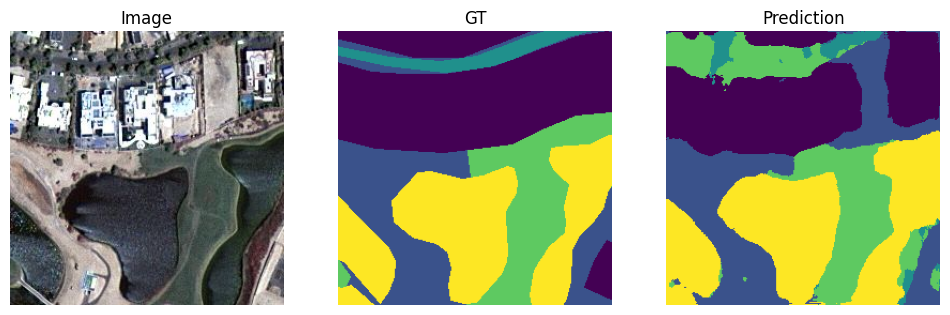

In [148]:
model.eval()
x, y = next(iter(val_loader))
x = x.to(device)

with torch.no_grad():
    pred = model(x)

pred = torch.argmax(pred, dim=1).cpu().numpy()
gt = y.numpy()
img = x.cpu().numpy().transpose(0, 2, 3, 1)

import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Image")
plt.imshow(img[i])
plt.axis("off")

plt.subplot(1,3,2)
plt.title("GT")
plt.imshow(gt[i])
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Prediction")
plt.imshow(pred[i])
plt.axis("off")
plt.show()


In [149]:
torch.save(model.state_dict(), "unet_resnet34.pth")